In [ ]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [ ]:
#Creating a dataframe with all the parameters of the options
def option_info_df(number_of_options):
    Expected_Price=int(input(f"Enter Expected Price of security:"))
    option_df=pd.DataFrame(columns=['Option Type','Strike Price','Premium','Expected/Current Price','Lots'])

    for i in range(number_of_options):
       Option_Characteristics=[]

       while True:
         Option_Type=input(f"Enter option {i+1} type:").lower()
         if Option_Type=='short call' or Option_Type=='short put' or Option_Type=='long call' or Option_Type=='long put':
              break
       Option_Characteristics.append(Option_Type)

       Strike_Price=int(input(f"Enter option {i+1} Strike Price:"))
       Option_Characteristics.append(Strike_Price)

       Premium=float(input(f"Enter option {i+1} Premium:"))
       Option_Characteristics.append(Premium)

       #Expected_Price=int(input(f"Enter option {i+1} Expected Price:"))
       Option_Characteristics.append(Expected_Price)

       number_of_lots=int(input(f"Enter option {i+1} lots:"))
       Option_Characteristics.append(number_of_lots)

       option_df.loc[len(option_df)] = Option_Characteristics

    option_df=option_df.sort_values("Strike Price")

    return option_df


# Define the symbolic variable
k = sp.symbols('k')


#Creating the headers for the payoff table
def payoff_table_headers(option_df):

    payoff_df=pd.DataFrame(columns=['Option Type'])

    i=0    #Variable declared to index in for loop below
    sp=[]  #List Carrying all the strike prices

    #Creating the list of tuples containing the strike prices and indexes
    for strike_price in option_df["Strike Price"]:
        sp.append((strike_price,i))
        i+=1

    #Creating the header row for the table
    for strike_price,i in sp:
        if i==0:
            payoff_df[f'{k}<{strike_price}']=''
        elif sp[i][0]!=sp[i-1][0]:                          #sp[i][0] is method to access particular element within a tuple in the list
            payoff_df[f'{sp[i-1][0]}<={k}<{sp[i][0]}']=''

    payoff_df[f'{k}>{sp[-1][0]}']=''

    return payoff_df

#Creating a list which helps with filling the payoff table
def psuedo_header_list(option_df):
    sp_new=[]

    for strike_price in option_df["Strike Price"]:
        sp_new.append(strike_price)

    temp=sp_new[0]
    sp_new.reverse()
    sp_new.append(temp-0.00001)
    sp_new.reverse()
    sp_new=list(set(sp_new))
    sp_new.sort()

    return sp_new


#Filling the payoff table
def table_entries(option_df,sp_new,payoff_df,number_of_options):

 payoff_row=[]

 for index, row in option_df.iterrows():
     payoff_row.append(row['Option Type'])
     if row['Option Type']=='long call':
         for sp in sp_new:
             if row['Strike Price']<=sp:
                 payoff_row.append(k*row['Lots']-row['Strike Price']*row['Lots'])
             elif row['Strike Price']>sp:
                 payoff_row.append(0)
     if row['Option Type']=='short call':
         for sp in sp_new:
             if row['Strike Price']<=sp:
                 payoff_row.append(row['Strike Price']*row['Lots']-k*row['Lots'])
             else:
                 payoff_row.append(0)
     if row['Option Type']=='long put':
         for sp in sp_new:
             if row['Strike Price']>sp:
                 payoff_row.append(row['Strike Price']*row['Lots']-k*row['Lots'])
             else:
                 payoff_row.append(0)
     if row['Option Type']=='short put':
         for sp in sp_new:
             if row['Strike Price']>sp:
                 payoff_row.append(k*row['Lots']-row['Strike Price']*row['Lots'])
             else:
                 payoff_row.append(0)
     payoff_df.loc[len(payoff_df)] = payoff_row
     payoff_row=[]

 payoff_df=payoff_df.set_index("Option Type")

 #Total sum per column:
 payoff_df.loc['Total Payoff',:] = payoff_df.sum(axis=0)

 payoff_df.loc['Total Premium/lot size=1',:] = net_premium(option_df,sp_new)

 total_profit = (payoff_df.iloc[number_of_options:number_of_options+2, :].sum())*25  # Calculate sum of last two rows
 payoff_df.loc['Total Profit'] = total_profit

 return payoff_df


#Calculating the net premium(Lot size is assumed to be 100)
def net_premium(option_df,sp_new):
    total_premium = 0

    for index, row in option_df.iterrows():
        if row['Option Type'] in ['long call', 'long put']:
            total_premium -= row['Premium'] * row['Lots']
        elif row['Option Type'] in ['short call', 'short put']:
            total_premium += row['Premium'] * row['Lots']

    premium_row=[]

    for i in range(len(sp_new)):
        premium_row.append(total_premium)

    return premium_row

#Finding the breakeven points
def breakeven_points(payoff_table_fnl,sp_temp,number_of_options):
    i=0

    breakeven_points = []

    for profit in payoff_table_fnl.loc['Total Profit']:
        solution=sp.solve(profit,k)
        if len(solution)==0:
            i+=1
            continue
        temp=int(solution[0])

        if i==0:
            if temp<sp_temp[1]:
                breakeven_points.append(temp)
        elif i==number_of_options:
            if temp>sp_temp[-1]:
                breakeven_points.append(temp)
        else:
            if temp>sp_temp[i] and temp<sp_temp[i+1]:
                breakeven_points.append(temp)
        i+=1

    return breakeven_points

#Calculating profits based on expected/current price
def fnl_profit(option_df,payoff_table_fnl,sp_temp,number_of_options):
    i=0
    expected_price=option_df.at[0,'Expected/Current Price']

    for profit in payoff_table_fnl.loc['Total Profit']:
        if i==0:
            if expected_price<sp_temp[1]:
                if len(sp.solve(profit,k))==0:
                   i+=1
                   return profit
                else:
                   substitued_value=profit.subs(k,expected_price)
                   evaluated_value=sp.N(substitued_value)
                   return evaluated_value
        elif i==number_of_options:
            if expected_price>sp_temp[-1]:
                if len(sp.solve(profit,k))==0:
                   i+=1
                   return profit
                else:
                   substitued_value=profit.subs(k,expected_price)
                   evaluated_value=sp.N(substitued_value)
                   return evaluated_value
        else:
            if expected_price>sp_temp[i] and expected_price<sp_temp[i+1]:
                if len(sp.solve(profit,k))==0:
                   i+=1
                   return profit
                else:
                   substitued_value=profit.subs(k,expected_price)
                   evaluated_value=sp.N(substitued_value)
                   return evaluated_value
        i+=1


#Calculating payoff for the differrent types of options
def short_call_payoff(strike_price, current_price_range, premium, lots):
    payoff = np.where(current_price_range <= strike_price, premium * lots, (strike_price - current_price_range + premium) * lots)
    return payoff

def long_call_payoff(strike_price, current_price_range, premium, lots):
    intrinsic_value = np.maximum(0, current_price_range - strike_price)
    return (intrinsic_value - premium) * lots

def short_put_payoff(strike_price, current_price_range, premium, lots):
    intrinsic_value = np.maximum(0, strike_price - current_price_range)
    return (-intrinsic_value + premium) * lots

def long_put_payoff(strike_price, current_price_range, premium, lots):
    intrinsic_value = np.maximum(0, strike_price - current_price_range)
    return (intrinsic_value - premium) * lots

#Plotting function
def plot_graph(option_df):
    expected_price=option_df.at[0,'Expected/Current Price']
    expected_price_range = np.linspace(expected_price - 2000, expected_price + 2000, 1000)

    fig, ax = plt.subplots()

    combined_payoff = np.zeros_like(expected_price_range)

    for index, option in option_df.iterrows():
        if option['Option Type'] == "short call":
            payoff = short_call_payoff(option['Strike Price'], expected_price_range, option['Premium'], option['Lots'])
        elif option['Option Type'] == "long call":
            payoff = long_call_payoff(option['Strike Price'], expected_price_range, option['Premium'], option['Lots'])
        elif option['Option Type'] == "short put":
            payoff = short_put_payoff(option['Strike Price'], expected_price_range, option['Premium'], option['Lots'])
        elif option['Option Type'] == "long put":
            payoff = long_put_payoff(option['Strike Price'], expected_price_range, option['Premium'], option['Lots'])

        combined_payoff += payoff
        ax.plot(expected_price_range, payoff, label=f'Strike Price: {option["Strike Price"]}, Option Type: {option["Option Type"].capitalize()}')

    # Plot combined payoff
    ax.plot(expected_price_range, combined_payoff, label='Combined Payoff', linestyle='solid', color='black')

    # Calculate x-axis range
    min_x =0
    #min_x = min(min(expected_price_range), expected_price)
    max_x = max(max(expected_price_range), expected_price) + 1000

    ax.set_xlabel('Current Price')
    ax.set_ylabel('Profit/Loss')
    ax.set_title('Option Payoff')
    ax.legend()
    ax.grid(True)

    # Adjust x-limits to include both the current price and the strike prices
    ax.set_xlim(min_x, max_x)

    # Calculate y-axis limits to ensure the combined payoff graph is visible
    combined_min_profit = combined_payoff.min()
    combined_max_profit = combined_payoff.max()
    ax.set_ylim(combined_min_profit-100, combined_max_profit+100)

    # Ensure the strike price axis intersects at profit=0
    ax.axhline(y=0, color='black', linestyle='--')

    plt.show()


Enter the number of options in your combination stratergy: 1
Enter Expected Price of security:100
Enter option 1 type:long call
Enter option 1 Strike Price:1
Enter option 1 Premium:1
Enter option 1 lots:1
                           k<1          k>1
Option Type                                
long call                  0.0        k - 1
Total Payoff               0.0        k - 1
Total Premium/lot size=1  -1.0         -1.0
Total Profit             -25.0  25*k - 50.0
breakeven points are:[2]
profit is:2450.00000000000


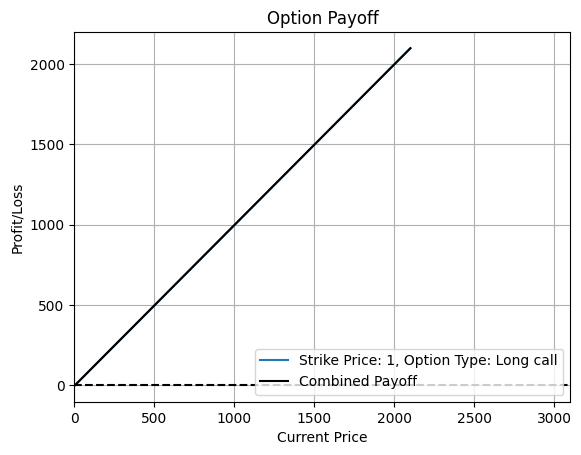

In [ ]:
number_of_options=int(input("Enter the number of options in your combination stratergy: "))

option_parameter_table=option_info_df(number_of_options)   #Collects all the parameters about the options of the stratergy

k = sp.symbols('k')    # Define the symbolic variable

payoff_headers_df=payoff_table_headers(option_parameter_table)

sp_temp=psuedo_header_list(option_parameter_table)

payoff_table_fnl=table_entries(option_parameter_table,sp_temp,payoff_headers_df,number_of_options)

print(payoff_table_fnl)

breakeven_values =breakeven_points(payoff_table_fnl,sp_temp,number_of_options)
print(f'breakeven points are:{breakeven_values}')

profit=fnl_profit(option_parameter_table,payoff_table_fnl,sp_temp,number_of_options)
print(f'profit is:{profit}')

plot_graph(option_parameter_table)



Project was uploaded on personal GitHub Repository however was unable to upload on the collaborative repo hence created a jupyter notebook.
